## Development notebook for improved montage view

### Boilerplate

In [1]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from dcmfetch import fetch_series
from mriqa.dcmio import coil_elements

### Test data

In [2]:
patid = 'PQACRK20161215'
studyid = '1'
series = {
    'Signal': [26, 30],
    'Noise': [22, 24]
}

### Montage

In [3]:
def show_montage(dobjs, dobjsb=None, op='mean', cmap=None, signed=False, title='Image Montage'):
    '''Display a list of dicom images or a multiframe as a single image montage.
       If two series are given then optionally combine as mean or difference.

       Parameters
       ----------
       dobjs : Sequence of dicom objects or single multiframe object or list with single multiframe to display
       dobjsb : Sequence of dicom objects to average or difference first with
       op : Operation between two series
       cmap : Optional colour map
       signed : set colour scale symmetrically about zero for a signed image
       title : Optional str

       Returns
       -------
       matplotlib axes object
    '''
    try:
        # wrap up in a list if passed as single dicom object
        images = [dobjs.pixel_array & 0xfff]
        dobjs = [dobjs]
    except AttributeError:
        images = [d.pixel_array & 0xfff for d in dobjs]

    if dobjsb is not None:
        try:
            # wrap up in a list if passed as single dicom object
            imagesb = [dobjsb.pixel_array & 0xfff]
            dobjsb = [dobjsb]
        except AttributeError:
            imagesb = [d.pixel_array & 0xfff for d in dobjsb]

        imagesb = np.asarray([d.pixel_array & 0xfff for d in dobjsb], dtype='int16')
        if op == 'mean':
            images = (images + imagesb) / 2
        elif op == 'diff':
            # nb signed
            images = images - imagesb
            signed = True

    have_mosaics = 'NumberofFrames' in dobjs[0] and dobjs[0].NumberofFrames > 1
    if have_mosaics:
        nframes = dobjs[0].NumberofFrames
        images = [frame for image in images for frame in image]

    try:
        # multi-element display if all images single element
        elements = [coil_elements(d) for d in dobjs]
        nelements = list(map(len, elements))
        if np.all(np.array(nelements) == 1):
            elements = [e[0] for e in elements]
            have_elements = True
        else:
            have_elements = False
    except IndexError:
        have_elements = False

    nimages = len(images)
    ncols = int(round(np.sqrt(nimages)))
    nrows = int(np.ceil(nimages / ncols))
    if ncols == 0 or nrows == 0:
        nrows = ncols = 1

    # construct montage image
    ny, nx = images[0].shape
    montage = np.zeros((ny*nrows, nx*ncols))
    for i, image in enumerate(images):
        x, y = (i % ncols) * nx, (i // ncols) * ny
        montage[y:y+ny, x:x+nx] = image

    fig, ax = plt.subplots(1, 1, figsize=(14, 14))

    if cmap is None:
        cmap = 'coolwarm' if signed else 'gray'
    textcolour = 'black' if signed else 'white'
            
    # display image
    mplim = ax.imshow(montage, cmap=cmap)
    ax.axis('image')
    ax.axis('off')
    
    # add labels
    x_0, y_0 = nx // 16, ny // 12
    for i in range(nimages):
        # text position
        x, y = x_0 + (i % ncols) * nx, y_0 + (i // ncols) * ny
        if have_mosaics:
            ax.text(
                x, y,
                'S%d/I%d/F%d' % (
                    dobjs[i//nframes].SeriesNumber,
                    dobjs[i//nframes].InstanceNumber,
                    i % nframes + 1
                ),
                color=textcolour
            )
        elif have_elements:
            ax.text(
                x, y,
                'S%d/E%d' % (
                    dobjs[i].SeriesNumber, elements[i] + 1
                ),
                color=textcolour
            )
        else:
            ax.text(
                x, y,
                'S%d/I%d' % (
                    dobjs[i].SeriesNumber, dobjs[i].InstanceNumber
                ),
                color=textcolour
            )

    ax.set_title(title, fontsize=16)

    # colourbar clipped to height of image
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(mplim, cax=cax)

    return ax

### Tests

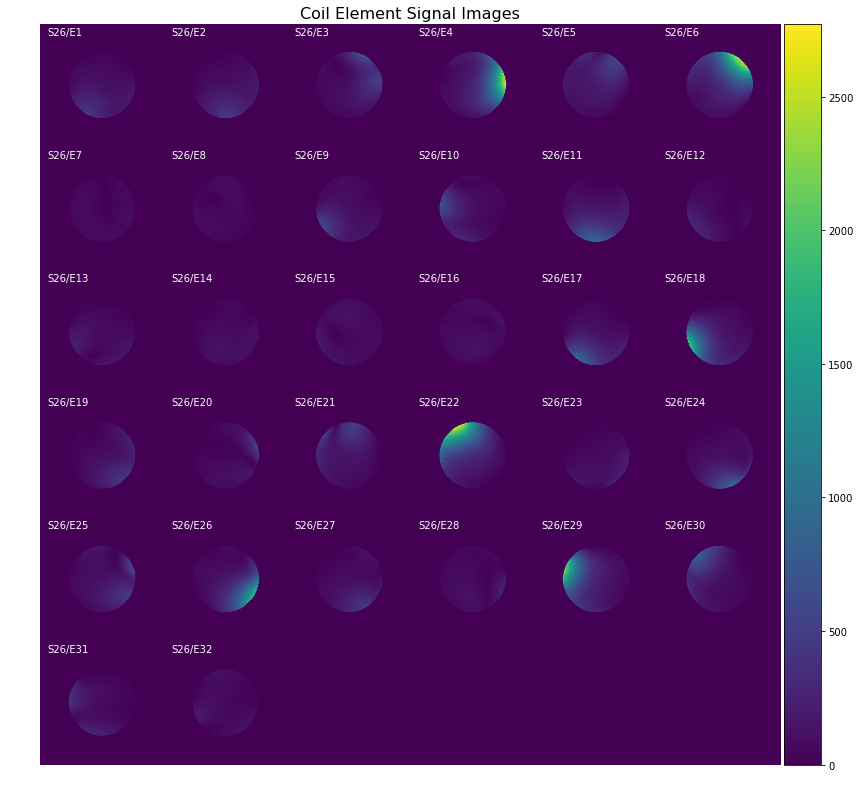

In [4]:
# Assume just one element
dobjs = sorted(
    fetch_series(patid, studyid, sernos=series['Signal']),
    key=lambda x: (int(x.SeriesNumber), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]

show_montage(dobjsa, dobjsb, op='mean', cmap='viridis', title='Coil Element Signal Images');

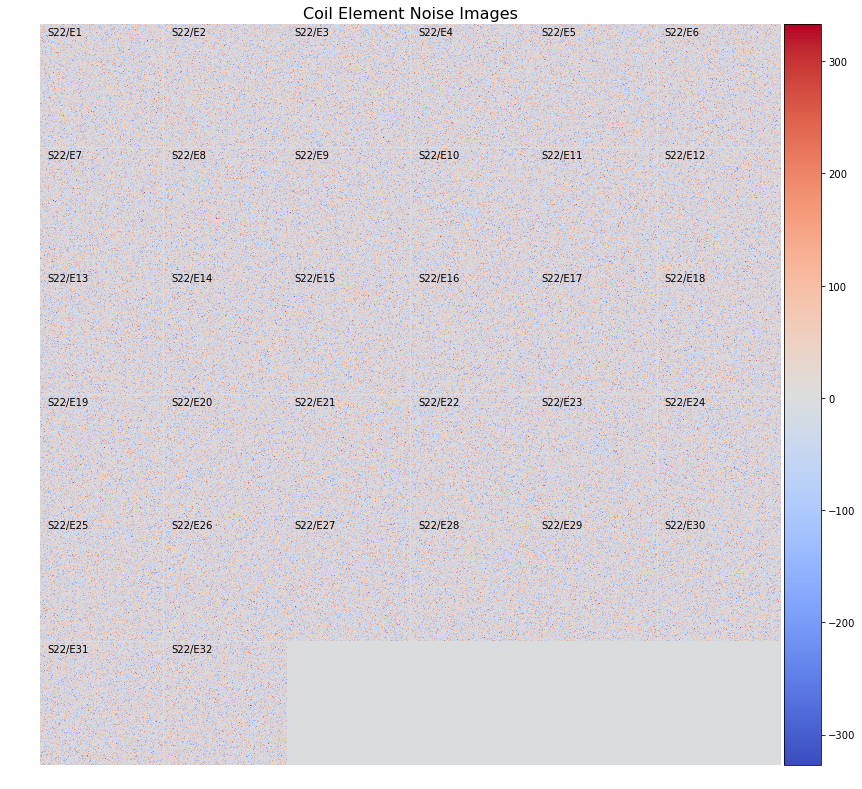

In [5]:
dobjs = sorted(
    fetch_series(patid, studyid, sernos=series['Noise']),
    key=lambda x: (int(x.SeriesNumber), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]
show_montage(dobjsa, dobjsb, op='diff', cmap='coolwarm', title='Coil Element Noise Images');